#  Data load and imports

Import of libraries and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

Get data

In [2]:
data = pd.read_csv('data/Data_Scientist_-_Case_Dataset.csv', delimiter=',')

In [3]:
data.columns

Index(['customer_id', 'converted', 'customer_segment', 'gender', 'age',
       'related_customers', 'family_size', 'initial_fee_level',
       'credit_account_id', 'branch'],
      dtype='object')

From the description of the data we know that the four variables: age, related customers, family size and initial fee level are numeric values. The remaining six variables (including the target variable, converted) are categorical values.

The customer id is unique for each customer which can be checked by checking that the length of the entire data set is the same as the unique number of customer ids:

In [4]:
len(data) == len(np.unique(data['customer_id']))

True

In [5]:
data

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
0,15001,0,13,male,22.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
1,15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere
2,15003,1,13,female,26.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
3,15004,1,11,female,35.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki
4,15005,0,13,male,35.0,0,0,16.1000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
...,...,...,...,...,...,...,...,...,...,...
886,15887,0,12,male,27.0,0,0,26.0000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
887,15888,1,11,female,19.0,0,0,60.0000,72294ba1616ddcaee48e56501040e876d26bd0c1839f3c...,Helsinki
888,15889,0,13,female,NaN,1,2,46.9000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
889,15890,1,11,male,26.0,0,0,60.0000,a2b612f45840d6f27b1a73ddae7f50e0bd9c4935903de6...,Tampere


To check for missing data, I will print the number of missing data points for each column that has any data missing:

In [6]:
for n in data.columns:
    data_nan = len(data[pd.isna(data[n]) == True])
    if data_nan > 0:
        print(f'Number missing data in {n} is {data_nan}, resulting in {len(data) - data_nan} useable data points for that variable.')

Number missing data in age is 177, resulting in 714 useable data points for that variable.
Number missing data in branch is 2, resulting in 889 useable data points for that variable.


# Visualizing the key influencer from PowerBI analysis

The automatic "key influencers"-function in PowerBI (posted in the pdf-file "PowerBI_analysis.pdf") identified the gender to be the most important factor when predicting whether a customer has converted or not. Therefore I will start by looking at the data for each gender.

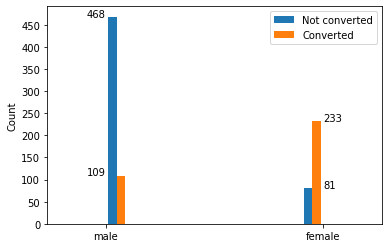

In [7]:
gender = data['gender']

plt.figure()
n, _, _ = plt.hist((gender[data['converted'] == 0], gender[data['converted'] == 1]), label = ['Not converted', 'Converted'])
plt.hlines(n[n != 0], -0.2, 1.2, alpha=0)
for i, nn in enumerate(n[n != 0]):
    if i%2:
        plt.text(1, nn, int(nn), ha='left', va='baseline')
    else:
        plt.text(0, nn, int(nn), ha='right', va='baseline')
plt.ylabel('Count')
plt.yticks(np.arange(0, np.max(n), step=50))
plt.legend(loc = 'best')
plt.show()

It is clear to see that gender is an important factor as females are disproportionally converted while males are not.

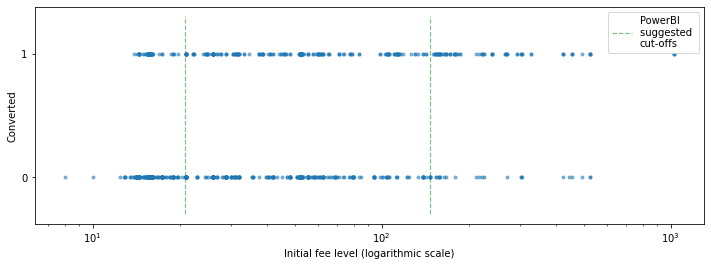

In [8]:
init_fee = data['initial_fee_level']

plt.figure(figsize=(12,4))
plt.plot(init_fee, data['converted'], '.', alpha=0.5)
plt.vlines([20.925, 147], -0.3, 1.3, linestyles='dashed', alpha=0.5, color='green', lw = 1.2, label='PowerBI \nsuggested \ncut-offs')
plt.xlabel('Initial fee level (logarithmic scale)')
plt.ylabel('Converted')
plt.yticks([0,1])
plt.xscale('log')
plt.legend()
plt.show()

This will be easier to see in a histogram

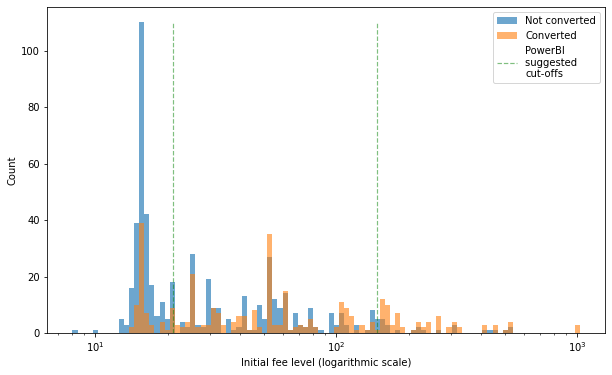

In [9]:
plt.figure(figsize=(10,6))

#The start point is the min value over 0 as it is not possible to calculate the log of 0
logbins=np.logspace(np.log10(min(init_fee[init_fee>0])),np.log10(max(init_fee)), 100)

n0, _, _ = plt.hist(init_fee[data['converted'] == 0],alpha=0.65, bins=logbins, label='Not converted')
n1, _, _ = plt.hist(init_fee[data['converted'] == 1],alpha=0.6, bins=logbins, label='Converted')
plt.vlines([20.925, 147], 0, max([*n0,*n1]), linestyles='dashed', alpha=0.5, color='green', lw = 1.2, label='PowerBI \nsuggested \ncut-offs')
plt.xlabel('Initial fee level (logarithmic scale)')
plt.ylabel('Count')
plt.xscale('log')
plt.legend()
plt.show()

It is very clear to see that especially the right cut-off at initial fee level > 147 contains a majority of converted customers, while a left cut-off at 20.925 has a majority of not converted customers. The middle section is a bit more muddy and in this section of the initial fee level is not a good sole factor to determine if a customer is converted or not.

Customer segment is the next on the list according to PowerBI

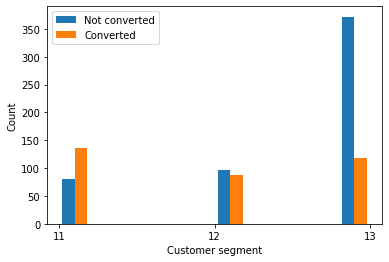

In [10]:
customer_segment = data['customer_segment']

plt.figure()
n, _, _ = plt.hist((customer_segment[data['converted'] == 0], customer_segment[data['converted'] == 1]), label = ['Not converted', 'Converted'])
plt.xticks(np.unique(customer_segment))
plt.yticks(np.arange(0, np.max(n), step=50))
plt.xlabel('Customer segment')
plt.ylabel('Count')
plt.legend(loc = 'best')
plt.show()

From this histogram it is seen that it is primarily in the customer segment 13 that this variable is good as a sole factor to determine if a customer is converted or not, as majority of customers in this segment are not converted. Segment 11 also have a little majority of customers being converted, but the difference between the number of converted and not converted customers is less

# Analysis in Python

I will use Cramer's V to determine how big correlation there is between the converted customers and the other variables. This is a test to test the relationship between two categorical variables which means that the continous variables will have to be put into categories. This will be on the cost of some precision, but this way the same test can be used for all variables. The result is a number between 0 and 1 for each variable pair, where 0 is no correlation and 1 is a strong correlation.


the customer_id column is dropped as this is a unique id for each customer and shouldnn't be 

In [11]:
data.head()

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
0,15001,0,13,male,22.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
1,15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere
2,15003,1,13,female,26.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
3,15004,1,11,female,35.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki
4,15005,0,13,male,35.0,0,0,16.1000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki


In [12]:
data_cramersV = data.copy(deep=True)

The customer credit account id is the same for all customers that don't have an id. I will refer to this id as the "generic id"

In [13]:
unique_ids = len(np.unique(data_cramersV['credit_account_id']))
print(f'Number of unique credit account ids is {unique_ids}')
gen_id = '9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0'
no_id = len(data_cramersV[data_cramersV['credit_account_id'] == gen_id])
print(f'Number of customers with no credit account ids is {no_id}')

Number of unique credit account ids is 148
Number of customers with no credit account ids is 687


While some ids other than the generic id are present more than once in the data set I will simply divide this variable into "id"/1 and "no id"/0 categories.

In [14]:
data_cramersV.loc[data_cramersV['credit_account_id'] == gen_id, 'credit_account_id'] = 0
data_cramersV.loc[data_cramersV['credit_account_id'] != 0, 'credit_account_id'] = 1

The customer ids are unique for each customer, but as I cannot rule out that time could have an effect (if the ids are given out in cronological order), I will also group them into categories. This will only count if the ids are given out in cronological order, otherwise possible detected correlations will be accidental

In [15]:
data_cramersV['customer_id'] = pd.cut(data['customer_id'], bins = 10)

In [16]:
checked_len = len(np.unique(data_cramersV['family_size']))
print(f'Number of categories in family size is {checked_len}')

checked_len = len(np.unique(data_cramersV['age']))
print(f'Number of ages is {checked_len}')

checked_len = len(np.unique(data_cramersV['initial_fee_level']))
print(f'Number of categories in initial fee level is {checked_len}')

checked_len = len(np.unique(data_cramersV['related_customers']))
print(f'Number of related customers is {checked_len}')

Number of categories in family size is 7
Number of ages is 89
Number of categories in initial fee level is 248
Number of related customers is 7


Here it is seen that the number of categories for the family size and the related customers are both 7. As this is a low amount of categories they are kept as is.

Age and initial fee level are both divided into categories.

Age will be divided into intervals of 10 years starting at 0 years of age and the last bin decided based on the oldest person in the data set.

In [17]:
print(max(data_cramersV['age']))

80.0


In [18]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80)])
data_cramersV['age'] = pd.cut(data['age'], bins = bins)

Initial fee level will be divided into logarithmic bins as there is far between the greater valued data as seen in the plots earlier

In [19]:
logbins = np.logspace(0,np.log10(max(init_fee)), 10)
data_cramersV['initial_fee_level'] = pd.cut(data['initial_fee_level'], bins = logbins)

In [20]:
len(pd.unique(data_cramersV['initial_fee_level']))

8

In [21]:
data_cramersV.head()

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
0,"(15000.11, 15090.0]",0,13,male,"(20, 30]",1,0,"(10.082, 21.779]",0,Helsinki
1,"(15000.11, 15090.0]",1,11,female,"(30, 40]",1,0,"(101.637, 219.564]",1,Tampere
2,"(15000.11, 15090.0]",1,13,female,"(20, 30]",0,0,"(10.082, 21.779]",0,Helsinki
3,"(15000.11, 15090.0]",1,11,female,"(30, 40]",1,0,"(101.637, 219.564]",1,Helsinki
4,"(15000.11, 15090.0]",0,13,male,"(30, 40]",0,0,"(10.082, 21.779]",0,Helsinki


At last the data needs to be encoded

In [22]:
label = preprocessing.LabelEncoder()
data_cramersV_encoded = pd.DataFrame() 

for i in data_cramersV.columns :
  data_cramersV_encoded[i] = label.fit_transform(data_cramersV[i])

### Define and run CramersV

Define the Cramers V function

In [23]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [24]:
cramersV_results_df = pd.DataFrame(index = data_cramersV.columns, columns = data_cramersV.columns)

cramersV_results = []
for row in data_cramersV.columns:
    for col in data_cramersV.columns:
        confusion_matrix = pd.crosstab(data_cramersV[row], data_cramersV[col])
        cramers_v_val = cramers_v(confusion_matrix.values)
        cramersV_results_df[col][row] = round(cramers_v_val, 2)


In [25]:
cramersV_results_df

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
customer_id,1.0,0.1,0.03,0.07,0.0,0.02,0.0,0.03,0.06,0.0
converted,0.1,1.0,0.34,0.54,0.11,0.19,0.16,0.34,0.31,0.17
customer_segment,0.03,0.34,1.0,0.13,0.26,0.15,0.02,0.63,0.79,0.26
gender,0.07,0.54,0.13,1.0,0.07,0.21,0.25,0.27,0.13,0.11
age,0.0,0.11,0.26,0.07,1.0,0.22,0.22,0.16,0.25,0.02
related_customers,0.02,0.19,0.15,0.21,0.22,1.0,0.24,0.25,0.14,0.09
family_size,0.0,0.16,0.02,0.25,0.22,0.24,1.0,0.19,0.09,0.05
initial_fee_level,0.03,0.34,0.63,0.27,0.16,0.25,0.19,1.0,0.64,0.21
credit_account_id,0.06,0.31,0.79,0.13,0.25,0.14,0.09,0.64,1.0,0.23
branch,0.0,0.17,0.26,0.11,0.02,0.09,0.05,0.21,0.23,1.0


In [26]:
results_arr = cramersV_results_df.values.astype('float64')

# Heatmap with the results
 
 Note that the diagonal will always be 1 as this is correlation between the variable itself.

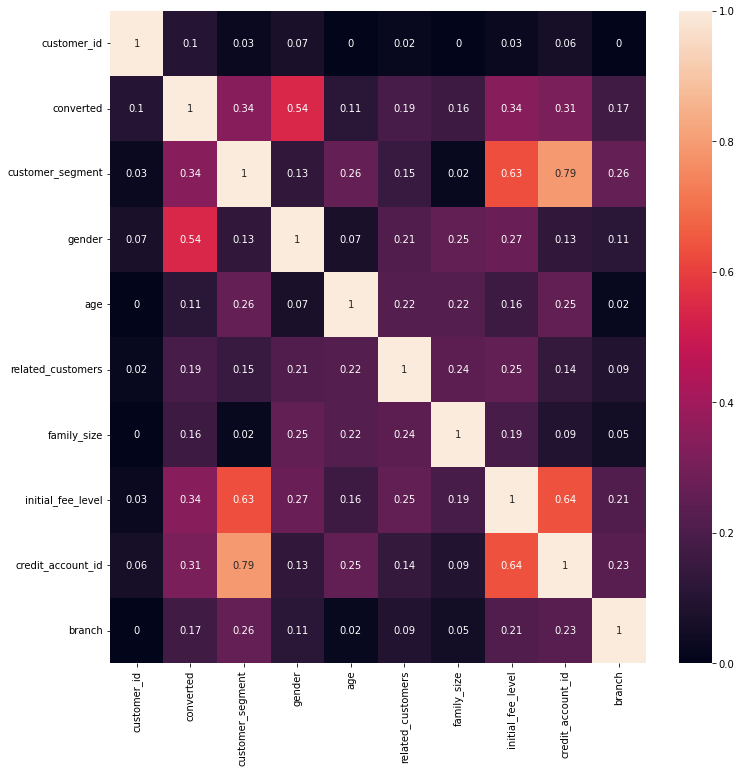

In [27]:
plt.figure(figsize=(12,12))
sns.heatmap(results_arr, annot=True, xticklabels=cramersV_results_df.columns, yticklabels=cramersV_results_df.columns)
plt.show()


##  Rundown of the different variables's correlation with "converted"   
#### Customer id
As expected is the customer id not correlated with anything.
#### Customer segment [one of the most imporant]
With a Cramer's V value of 0.34 there is some correlation between customer segment and whether a sustomer is converted or not. This is also clear to see in the histogram plotted in the beginning of this document where customer segment 13 has a majority of the customers being not converted. The rest of the segments don't have a strong relationship with "converted" which is probably what drags the Cramer's V value down.
#### Gender [one of the most imporant]
The results from Cramer's V supports the PowerBI analysis that the gender is the most important factor in determining if a customer is converted or not. The result of 0.54 in the Cramer's V is however not a very strong correlation (as the result is between 0 and 1 with 1 being the perfect correlation) and should not stand alone if one is to predict a customer's conversion status.
#### Age
Besides the customer id, age is the least important factor in relation to "converted". It is also not present in neither key influencers nor top segments in the PowerBI nalysis.
#### Related customers
The number of related customers do not have a high Cramer's V value, but do show up as one of the weaker key influencers and in some of the segments in the PowerBI analysis. Alone it is therefore not an important factor compared to other available factors, but can in combination with other factors help determine if a customer is converted.
#### Family size
Family size has a fairly low Cramer's V value of 0.16, but is included as one of the weaker key influencers in the PowerBI analysis as well as is included in some of the segments for "not converted". Alone it is thus not one of the most important factors, but can help in combination with other factors.
#### Initial fee level [one of the most imporant]
Together with customer segment this has a Cramer's V value of 0.34, which is the second to highest correlation value. It is therefore one of the three most important sole factors together with the segment and gender. 
#### Credit account id
Credit account id has a fairly high Cramer's V value (0.31) when considering that it did not show up in the PowerBI analysis. This most likely has to do with that it was separated into just two categories in this analysis based on whether the customer had an id or not. Here it thus seems that there is some correlation between whether or not a customer has an id or not, but not necessarily with the specific id itself. 
#### Branch
Like the family size, branch has one of the lower Cramer's V values of 0.17, and is likewise not one of the most important factors. Some of the specific branches are however named as key influencers by PowerBI and are included in some segments. Like with the rest it can thus with fine results be used together with other factors.

## Extra notes

It is important to note that this analysis is based on looking at "converted"'s relationship with one variable at the time. Therefore stronger correlations that can be used in predictions of a customer's conversion status can be made if several factors are combined. This is supported in th PowerBI key influencer analysis where several segments consisting of 3-5 factors have a very high percentage af correct classification of "converted" based on the chosen intervals of those factor. 

Furthermore, while the initial fee level and the customer segment both have the second highest correlation score of 0.34, their reciprocal correlation score are quite high (0.63), and having both in the same model would therefore propably not make such a big difference in the prediction as one could expect looking only at their correltions with "converted".

# Modelling for hypothesis testing
From the Cramer's V test and the Power BI test we now have a hypothesis that the gender, initial fee level and the customer segment are the three most important factors in predicting if a customer is converted (though having the last two in the same model may not make such a big difference in the predtion of "converted" as face value would suggest - see note above). Whether a customer has a customer id or not is furthermore also an important factor according to the tests, though the specific customer id is not. 
Vice versa this means that related customers, branch, family size, age and lastly customer id are not essential factors for whether a customer is converted or not.

To test this hypothesis a logistic regression using the different factors is made. By using a logistic regression as a model, a probability of conversion will be outputted based on the input factors chosen. By checking how well the model predicts the outcome using different sets of input variables, it can be used to determine if the hypothesis is indeed correct and those are the most important factors. 

#### Plotting the ROC curves 
Ideally we want the highest possible True Positive Rate (TPR = TP/T) with the lowest possible False Positive Rate (FPR=FP/N) which means that we are interested in the model closest to the upper left corner/that has the biggest area under the curve (AUC). The accuracy (ACC = (TP+TN)/(P+N)) gives a picture of how well the models perform when asking for an automatic binary prediction instead of a probability of converted where the threshold for when the prediction should count as converted can be chosen to lie elsewhere than what it is in the automatic prediction.

---

Beneath 10 logistic regression models with different combinations of contained factors are being made. As a simpler model using as few factors as possible is desireable and the Cramer's V has given an indication of which factors has the biggest correlation with converted alongside their internal correlations, the factors chosen for the models are centered around the highest correlating factors in relation to converted and only 2-4 factors are used in each model. To test if the Cramer's V is reliable, some models are centered partly or entirely around worsely correlated factors in relation to converted to compare their performance with the models that are hypothesized to perform well.

In [42]:
class logitRegInvestigation:
    def __init__(self, list_of_var_label, Draw_ROC_Curves_Class, color = []):
        self.Draw_ROC_Curves_Class = Draw_ROC_Curves_Class

        self.drop_stars(list_of_var_label)
        self.fit_logreg()
        self.predict_on_model()
        self.evaluate_model()
        self.add_model_to_graph(list_of_var_label, color)
    
    def drop_stars(self, list_of_var_label):
        list_of_var = list_of_var_label.replace('*', '').replace(' ', '_').lower()
        self.list_of_var = list(list_of_var.split(',_'))
    
    def fit_logreg(self):
        self.make_data_split()
        self.logreg = LogisticRegression(solver='liblinear')
        self.logreg.fit(self.x_train, self.y_train)
    
    def make_data_split(self):
        #Seed for randomization chosen for reproducability and consistency across the different choices of columns
        random_seed = 571011
        test_size = 0.2
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            data_cramersV_encoded[self.list_of_var],
            data_cramersV_encoded['converted'],
            test_size=test_size,
            random_state=random_seed)
    
    def predict_on_model(self):
        self.y_pred = self.logreg.predict(self.x_test)

    def evaluate_model(self):
        self.accuracy = self.logreg.score(self.x_test, self.y_test)
        self.AUC = metrics.roc_auc_score(self.y_test, self.logreg.predict(self.x_test))
        self.fpr, self.tpr, self.thresholds = metrics.roc_curve(self.y_test, self.logreg.predict_proba(self.x_test)[:,1])
    
    def add_model_to_graph(self, list_of_var_label, color):
        self.Draw_ROC_Curves_Class.add_ROC_curve(self.fpr, self.tpr, self.AUC, self.accuracy, list_of_var_label, color)


class Draw_ROC_Curves:
    def __init__(self):
        self.make_base()
    
    def make_base(self):
        plt.figure(figsize=(12,12))
        plt.grid(lw = 0.5)
        plt.plot([0, 1], [0, 1],'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xticks(np.arange(0, 1.01, step=0.1))
        plt.yticks(np.arange(0, 1.01, step=0.1))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-curve - logistic regressions')
    
    def zoom_upper_left_corner(self):
        plt.xlim([0, 0.7])
        plt.ylim([0.3, 1.0])
        plt.xticks(np.arange(0, 0.71, step=0.1))
        plt.yticks(np.arange(0.3, 1.01, step=0.1))

    def add_ROC_curve(self, fpr, tpr, area, acc, list_of_var, color = []):
        if color == []:
            plt.plot(fpr, tpr, label= list_of_var + '\n        (area = %0.4f;     ACC = %0.4f)' % (area, acc))
        else:
            plt.plot(fpr, tpr, label= list_of_var + '\n        (area = %0.4f;     ACC = %0.4f)' % (area, acc), color = color)

    def draw_plot(self):
        plt.legend(loc="lower right")
        plt.show()

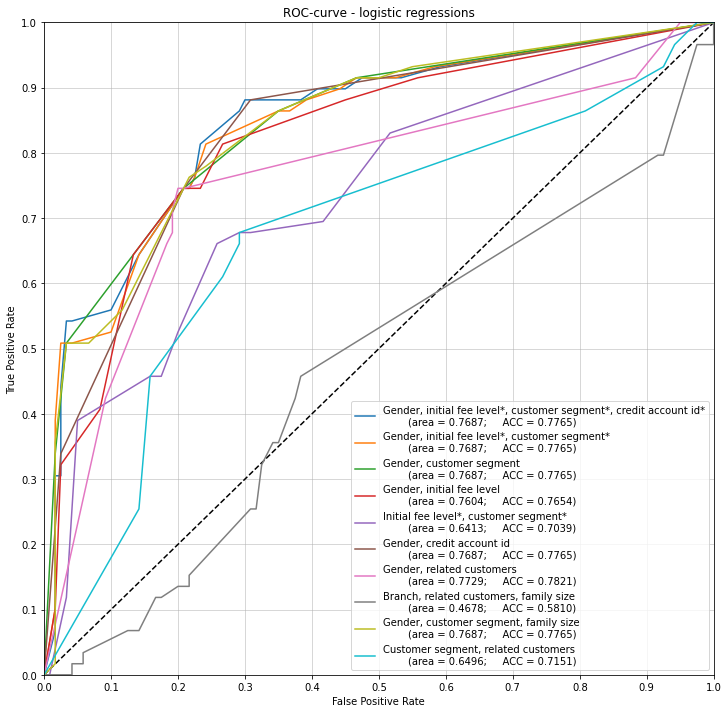

In [43]:
label_list = [
    'Gender, initial fee level*, customer segment*, credit account id*',
    'Gender, initial fee level*, customer segment*',
    'Gender, customer segment',
    'Gender, initial fee level',
    'Initial fee level*, customer segment*',
    'Gender, credit account id',
    'Gender, related customers',
    'Branch, related customers, family size',
    'Gender, customer segment, family size',
    'Customer segment, related customers'
]

ROC_Curve_Class = Draw_ROC_Curves()
for label in label_list:
    logitRegInvestigation(label, ROC_Curve_Class)
ROC_Curve_Class.draw_plot()

**NOTE:** Those variables marked with \* are highly correlated (>0.50) with one of the other variables with the \* mark used in the same logistic regression model. This is not advisable as having both in the same model shouldn't provide much extra info about the target variable (converted) even when each of them are highly correlated with the target. 

It is also seen that those with this marking don't perform better compared to the other models when taking into account the number of variables in the models. This is especially seen with the blue model using the gender, initial fee level, customer segments and credit account id. Despite these four variables being the four best correlated variables with converted, the model has the a AUC just smaller than the green model using only the gender and customer segment. As fewer variables giving a simpler model is also desireable, there would be no reason to chose the more complex blue (or orange) model(s) over the simpler green model when the difference in AUC is negligible.



To compare the models using factors with a high correlation with converted according to the Cramer's V, a model using three factors branch, familiy size and related customers has also been tried out (grey model). Common for these three factors is that they their correlations with converted are in the middle compared to the other available factors. With a AUC<0.5 and a curve that twists around the dashed, black line visualizing where a model guessing randomly would be, there is no doubt that these factors are not important when predicting if a customer has converted or not. While age and customer id has not been included in any models, with this test of the grey model toggether with their low correlation scores from Cramer's V, there is no reason to believe that these would be important.

---

A few of the models are selected to get a better look in the left upper corner. The models chosen are those without a \* mark that also has an AUC > 0.75

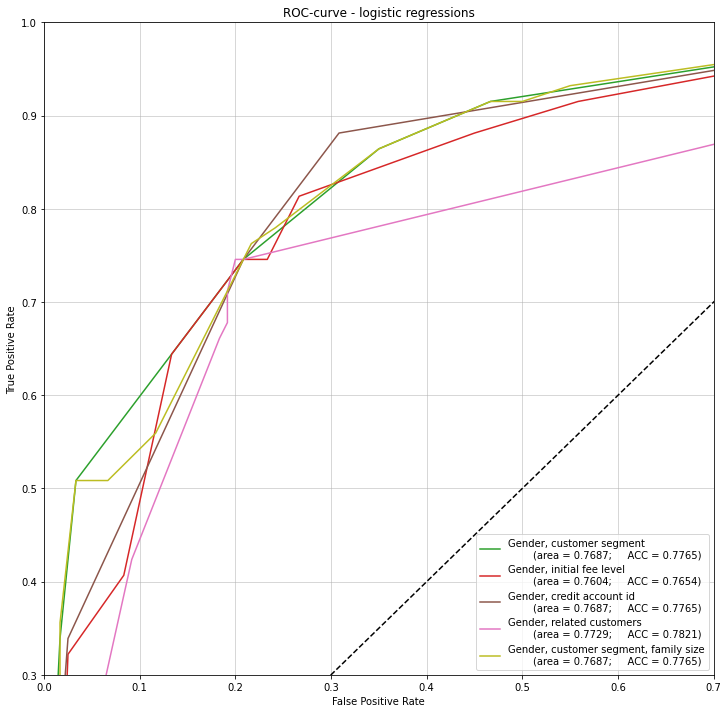

In [44]:
label_list = [
    'Gender, customer segment',
    'Gender, initial fee level',
    'Gender, credit account id',
    'Gender, related customers',
    'Gender, customer segment, family size'
]
color_list = [
    'tab:green',
    'tab:red',
    'tab:brown',
    'tab:pink',
    'tab:olive'
]

ROC_Curve_Class = Draw_ROC_Curves()
for label, color in zip(label_list, color_list):
    logitRegInvestigation(label, ROC_Curve_Class, color)
ROC_Curve_Class.zoom_upper_left_corner()
ROC_Curve_Class.draw_plot()

Here it is seen that four of the five chosen models has more or less the same shape while the last model (pink: gender and related customer) for the most part lies beneath the rest. 

Depending on whether one is more willing to get a greater risk of a not converted customer being predicted as converted in exchange for having a large percentage of the converted customers being correctly identifyed (getting a high TPR, but also accepting a possible high FPR), or if one is more interested in being certain not to get any false alarms, and thus catching fewer of the converted customers using the model, there could be difference in which model is most desireable. In the first case the brown model (using gender and credit account id) seems to be the better choice unless a FPR > 0.42 (approx.) is accepted, while in the latter case, the green model (using gender and customer segment) seems to be the better choice. There is however a "random" selection of the training and test sets as well as what data that is available to begin with that has an effect on the exact shape of the ROC curves as well as the AUC. As the paths and AUC-scores are quite close, it is therefore not certain that the true difference in the model's predictions are significantly different. 

Taking the Cramer's V scores into account with the AUCs for the different models, the best model seems to be the green model using gender and customer segment in its prediction. It is both the model with the highest AUC as well as two of the top three best factors according to the Cramer's V test. This differs from the initial hypothesis that contained all three of the best scoring factors according to the Cramer's V test. This is easily explained by the high correlation between customer segment and initial fee level which means that having both in the same model would not give much extra info. Being able to make the model using only two instead of all three factors with the highest correlation with converted without losing information also goes well with the desire to have a simpler model.

# Conclusion
In conclusion **gender** is the most important factor when predicting if a customer has converted or not. While both customer segment and initial fee level are equally correlated with converted, the correlation between gender and customer segment compared with gender's correlation with initial fee level is smaller, and **customer segment** is thus the best factor to combine with gender to predict whether a customer has converted. 